In [1]:
import sys
import os
import itertools

base_path = os.path.dirname(os.path.dirname(os.path.abspath(".")))
sys.path.append(base_path)

import torch.optim as optim
import numpy as np
from tqdm import tqdm
import logging


from utils.config import img_param_init, set_random_seed
from utils.dataload import DomainDataset, get_data
from model.clip import ClipModelMA, Adapter, Client
from process import train_client, communicate, test_server, test_client, fetch
class argparser():
   dataset = 'officehome'
   root_dir='/mnt/sda/zd/data/splitdata_new/'
   net='ViT-B/16'
   seed=0
   logdir=None
   device="cuda:0"
   n_clients=10
   n_experts=5
   inner_iter=10
   n_task=10
   # data setting parameter
   datapercent=8e-1
   batch=100
   # optimizer parameter
   lr=2e-3
   beta1=0.9
   beta2=0.98
   eps=1e-6
   weight_decay=0.2
import logging
def init():
    args = argparser()
    if args.logdir is not None:
        logging.basicConfig(filename=args.logdir, level=logging.DEBUG)
    else:
        logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
    args.random_state = np.random.RandomState(1)
    set_random_seed(args.seed)
    args = img_param_init(args)  # init the dataset parameters(domains and classnum)
    args.thresh = 1e-4
    return args

In [2]:
print(1)

1


In [3]:
    
def init():
    args = argparser()
    if args.logdir is not None:
        logging.basicConfig(filename=args.logdir, level=logging.DEBUG)
    else:
        logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
    args.random_state = np.random.RandomState(1)
    set_random_seed(args.seed)
    args = img_param_init(args)  # init the dataset parameters(domains and classnum)
    args.thresh = 1e-4
    return args

In [4]:
def freeze_param(model):
    for name, param in model.named_parameters():
        param.requires_grad = False
args = init()

args.dataset = "officehome"
args.root_dir = "/mnt/sda/zd/data/OF10-10-1000-2023/"

logging.info("Argument init successful!")
server_model: ClipModelMA = ClipModelMA(args.net, n_experts=args.n_experts, device=args.device)  # load the server data
dataloader: DomainDataset = get_data(args.dataset)(args, server_model.preprocess)
train_loaders, test_loaders, labels = dataloader.get_dataloader(8)
assert len(train_loaders) == args.n_clients, "This just mention you to make sure the n_clients \
                                            equals to the datasplit client number."
server_model.labels = labels
server_model.init_prompt()
server_model.init_MoE()
freeze_param(server_model.model)
logging.info("Data init successful!")



Argument init successful!
loading data in /mnt/sda/zd/data/OF10-10-1000-2023/client0/task8/Clipart
loading data in /mnt/sda/zd/data/OF10-10-1000-2023/client1/task8/Product
loading data in /mnt/sda/zd/data/OF10-10-1000-2023/client2/task8/Real World
loading data in /mnt/sda/zd/data/OF10-10-1000-2023/client3/task8/Art
loading data in /mnt/sda/zd/data/OF10-10-1000-2023/client4/task8/Clipart
loading data in /mnt/sda/zd/data/OF10-10-1000-2023/client5/task8/Product
loading data in /mnt/sda/zd/data/OF10-10-1000-2023/client6/task8/Real World
loading data in /mnt/sda/zd/data/OF10-10-1000-2023/client7/task8/Art
loading data in /mnt/sda/zd/data/OF10-10-1000-2023/client8/task8/Clipart
loading data in /mnt/sda/zd/data/OF10-10-1000-2023/client9/task8/Product
loading data in /mnt/sda/zd/data/OF10-10-1000-2023/test/Clipart with ['Clipart', 'Product', 'Real World', 'Art']
loading data in /mnt/sda/zd/data/OF10-10-1000-2023/test/Product with ['Clipart', 'Product', 'Real World', 'Art']
loading data in /mnt

In [5]:
import torch
server_model.MoE.gating.load_state_dict(torch.load("save/gating8.pkl"))
server_model.MoE.gating.to(args.device)

Sequential(
  (0): Linear(in_features=768, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=512, out_features=5, bias=True)
)

In [6]:
# from torch.utils.data import TensorDataset, DataLoader
clients_data = [Client("ViT-B/16", args.device) for _ in range(10)]
with torch.no_grad():
    all_feature = []
    for idx, client_loader in tqdm(enumerate(train_loaders)):
        temp_hook = server_model.model.visual.transformer.resblocks[5].register_forward_hook(clients_data[idx].extract_feature())
        for image,_,_ in client_loader:
            server_model.model.encode_image(image.to(args.device))
        temp_hook.remove()

        single_feature = []
        temp_data = torch.tensor(clients_data[idx].preprocess(), dtype=torch.float)
        temp_array = np.array([0 for i in range(args.n_experts)], dtype=np.float64)
        for i, data in enumerate(temp_data):
            res = server_model.MoE.gating(data.to(args.device))
            # print(np.array(res.cpu()))
            temp_array += np.array(res.cpu(), dtype=np.float64)
            if (i%20) == 0:
                single_feature.append(temp_array/20)
                temp_array = np.array([0 for i in range(args.n_experts)],dtype=np.float64)
        all_feature.append(np.stack(single_feature))
all_feature = np.vstack(all_feature)
all_feature.shape    


10it [00:44,  4.43s/it]


(250, 5)

In [7]:
np.save("OF.dat", all_feature)

DEBUG:matplotlib:matplotlib data path: /home/zd/miniconda3/envs/fedclip/lib/python3.8/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:CONFIGDIR=/home/zd/.config/matplotlib
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is linux
DEBUG:matplotlib:CACHEDIR=/home/zd/.cache/matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /home/zd/.cache/matplotlib/fontlist-v330.json


执行t-SNE降维
可视化数据并使用标签着色
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/zd/miniconda3/envs/fedclip/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymReg.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/zd/miniconda3/envs/fedclip/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/cmmi10.ttf', name='cmmi10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/zd/miniconda3/envs/fe

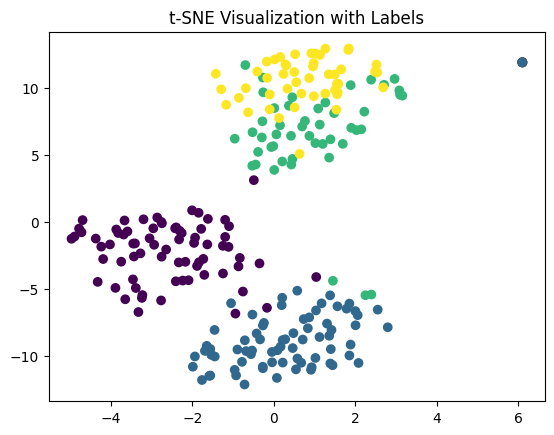

In [8]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import itertools

label = [0,1,2,3,0,1,2,3,0,1]
labels = itertools.chain.from_iterable([[i]*25 for i in label ])

print("执行t-SNE降维")
tsne = TSNE(n_components=2, perplexity=50, learning_rate=1, random_state=42)
tsne_result = tsne.fit_transform(all_feature)

print("可视化数据并使用标签着色")
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=list(labels))  # 使用'viridis'颜色地图
plt.title("t-SNE Visualization with Labels")
# plt.colorbar()
plt.show()

# DoaminNet

In [9]:
import sys
import os
import itertools

base_path = os.path.dirname(os.path.dirname(os.path.abspath(".")))
sys.path.append(base_path)

import torch.optim as optim
import numpy as np
from tqdm import tqdm
import logging


from utils.config import img_param_init, set_random_seed
from utils.dataload import DomainDataset, get_data
from model.clip import ClipModelMA, Adapter, Client
from process import train_client, communicate, test_server, test_client, fetch
class argparser():
   dataset = 'domainnetsub'
   root_dir='/mnt/sda/zd/data/DN20-10-2000-2023'
   net='ViT-B/16'
   seed=0
   logdir=None
   device="cuda:0"
   n_clients=20
   n_experts=8
   inner_iter=10
   n_task=10
   # data setting parameter
   datapercent=8e-1
   batch=100
   # optimizer parameter
   lr=2e-3
   beta1=0.9
   beta2=0.98
   eps=1e-6
   weight_decay=0.2
import logging
def init():
    args = argparser()
    if args.logdir is not None:
        logging.basicConfig(filename=args.logdir, level=logging.DEBUG)
    else:
        logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
    args.random_state = np.random.RandomState(1)
    set_random_seed(args.seed)
    args = img_param_init(args)  # init the dataset parameters(domains and classnum)
    args.thresh = 1e-4
    return args

In [10]:
    
def init():
    args = argparser()
    if args.logdir is not None:
        logging.basicConfig(filename=args.logdir, level=logging.DEBUG)
    else:
        logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
    args.random_state = np.random.RandomState(1)
    set_random_seed(args.seed)
    args = img_param_init(args)  # init the dataset parameters(domains and classnum)
    args.thresh = 1e-4
    return args

In [11]:
def freeze_param(model):
    for name, param in model.named_parameters():
        param.requires_grad = False
args = init()

args.dataset = "domainnetsub"
args.root_dir = "/mnt/sda/zd/data/DN20-10-2000-2023"

logging.info("Argument init successful!")
server_model: ClipModelMA = ClipModelMA(args.net, n_experts=args.n_experts, device=args.device)  # load the server data
dataloader: DomainDataset = get_data(args.dataset)(args, server_model.preprocess)
train_loaders, test_loaders, labels = dataloader.get_dataloader(8)
assert len(train_loaders) == args.n_clients, "This just mention you to make sure the n_clients \
                                            equals to the datasplit client number."
server_model.labels = labels
server_model.init_prompt()
server_model.init_MoE()
freeze_param(server_model.model)
logging.info("Data init successful!")



Argument init successful!
loading data in /mnt/sda/zd/data/DN20-10-2000-2023/client0/task8/quickdraw
loading data in /mnt/sda/zd/data/DN20-10-2000-2023/client1/task8/real
loading data in /mnt/sda/zd/data/DN20-10-2000-2023/client10/task8/sketch
loading data in /mnt/sda/zd/data/DN20-10-2000-2023/client11/task8/clipart
loading data in /mnt/sda/zd/data/DN20-10-2000-2023/client12/task8/quickdraw
loading data in /mnt/sda/zd/data/DN20-10-2000-2023/client13/task8/real
loading data in /mnt/sda/zd/data/DN20-10-2000-2023/client14/task8/painting
loading data in /mnt/sda/zd/data/DN20-10-2000-2023/client15/task8/infograph
loading data in /mnt/sda/zd/data/DN20-10-2000-2023/client16/task8/sketch
loading data in /mnt/sda/zd/data/DN20-10-2000-2023/client17/task8/clipart
loading data in /mnt/sda/zd/data/DN20-10-2000-2023/client18/task8/quickdraw
loading data in /mnt/sda/zd/data/DN20-10-2000-2023/client19/task8/real
loading data in /mnt/sda/zd/data/DN20-10-2000-2023/client2/task8/painting
loading data in 

In [12]:
import torch
server_model.MoE.gating.load_state_dict(torch.load("save/gatingDN8.pkl"))
server_model.MoE.gating.to(args.device)

Sequential(
  (0): Linear(in_features=768, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=512, out_features=8, bias=True)
)

In [13]:
# from torch.utils.data import TensorDataset, DataLoader
clients_data = [Client("ViT-B/16", args.device) for _ in range(20)]
with torch.no_grad():
    all_feature_DN = []
    for idx, client_loader in tqdm(enumerate(train_loaders)):
        temp_hook = server_model.model.visual.transformer.resblocks[8].register_forward_hook(clients_data[idx].extract_feature())
        for image,_,_ in client_loader:
            server_model.model.encode_image(image.to(args.device))
        temp_hook.remove()

        single_feature = []
        temp_data = torch.tensor(clients_data[idx].preprocess(), dtype=torch.float)
        temp_array = np.array([0 for i in range(args.n_experts)], dtype=np.float64)
        for i, data in enumerate(temp_data):
            res = server_model.MoE.gating(data.to(args.device))
            # print(np.array(res.cpu()))
            temp_array += np.array(res.cpu(), dtype=np.float64)
            if (i%20) == 0:
                single_feature.append(temp_array/20)
                temp_array = np.array([0 for i in range(args.n_experts)],dtype=np.float64)
        all_feature_DN.append(np.stack(single_feature))
all_feature_DN = np.vstack(all_feature_DN)
all_feature_DN.shape

0it [00:00, ?it/s]

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 2604
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 2269
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 3369
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 2303
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 2837
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 2231
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 3306
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 2753
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 3155
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 3108
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngI

4it [00:11,  2.80s/it]

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 2557
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 2828
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 2272
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 2140
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 1354
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 2716
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 2745
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 1848
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 2589
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 1988
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngI

10it [00:29,  3.09s/it]

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 3670
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 3453
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 1804
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 2125
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 2525
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 1772
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 2093
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 1544
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 2754
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 1968
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngI

16it [00:48,  3.15s/it]

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 3619
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 2600
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 2025
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 1772
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 2668
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 2198
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 1301
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 2873
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 2234
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 1767
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngI

20it [01:01,  3.07s/it]


(500, 8)

执行t-SNE降维
可视化数据并使用标签着色


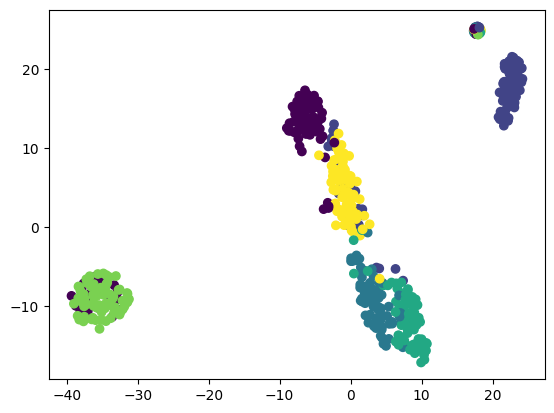

In [14]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import itertools

label_DN = [0,1,2,3,4,5,0,1,2,3,4,5,0,1,2,3,4,5,0,1]
labels_DN = itertools.chain.from_iterable([[i]*25 for i in label_DN ])

print("执行t-SNE降维")
tsne = TSNE(n_components=2, perplexity=40, learning_rate=100, random_state=42)
tsne_result = tsne.fit_transform(all_feature_DN)

print("可视化数据并使用标签着色")
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=list(labels_DN))  # 使用'viridis'颜色地图
# plt.title("t-SNE Visualization with Labels")
# plt.colorbar()
plt.show()

DEBUG:matplotlib.backends.backend_pdf:Assigning font /F1 = '/home/zd/miniconda3/envs/fedclip/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif.ttf'
DEBUG:matplotlib.backends.backend_pdf:Embedding font /home/zd/miniconda3/envs/fedclip/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif.ttf.
DEBUG:matplotlib.backends.backend_pdf:Writing TrueType font.


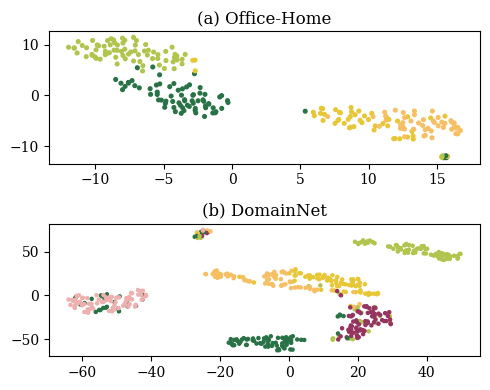

In [19]:
# labels_DN
# labels
# all_feature
# all_feature_DN
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['no-latex', 'scatter'])
import numpy as np
# palette = ["#287246", "#B1C44D", "#E7C736", "#F7BF63", "#EEB0AF","#963460","#631F66", "#01899D"]
# label_DN =  ["#287246", "#B1C44D", "#E7C736", "#F7BF63", "#EEB0AF","#963460","#287246", "#B1C44D", "#E7C736", "#F7BF63", "#EEB0AF","#963460","#287246", "#B1C44D", "#E7C736", "#F7BF63", "#EEB0AF","#963460","#287246", "#B1C44D"]
# label = ["#287246", "#B1C44D", "#E7C736", "#F7BF63", "#287246", "#B1C44D", "#E7C736", "#F7BF63","#287246", "#B1C44D"]
label_DN = ["#14517C", "#2F7FC1", "#E7EFFA" ,"#96C37D", "#F3D266", "#D8383A", "#14517C", "#2F7FC1", "#E7EFFA" ,"#96C37D", "#F3D266", "#D8383A", "#14517C", "#2F7FC1", "#E7EFFA" ,"#96C37D", "#F3D266", "#D8383A", "#14517C", "#2F7FC1"]  
label = ["#2F7FC1", "#96C37D", "#F3D266", "#D8383A", "#2F7FC1", "#96C37D", "#F3D266", "#D8383A","#2F7FC1", "#96C37D"]
palette = ["#14517C", "#2F7FC1", "#E7EFFA" ,"#96C37D", "#F3D266", "#D8383A"]
plt.rcParams.update({'font.family': 'serif'})

labels_DN = list(itertools.chain.from_iterable([[i]*25 for i in label_DN ]))
labels = list(itertools.chain.from_iterable([[i]*25 for i in label ]))


plt.rcParams.update({'font.family': 'serif'})
tsne_OF = TSNE(n_components=2, perplexity=40, learning_rate=100, random_state=42)
tsne_result_OF = tsne_OF.fit_transform(all_feature)
tsne_DN = TSNE(n_components=2, perplexity=10, learning_rate=400, random_state=42)
tsne_result_DN = tsne_DN.fit_transform(all_feature_DN)
fig, axes = plt.subplots(2, 1, figsize=(5, 4))

axes[0].scatter(tsne_result_OF[:, 0], tsne_result_OF[:, 1], c=list(labels), s=7)
axes[0].set_title('(a) Office-Home')


# Plot for DN
axes[1].scatter(tsne_result_DN[:, 0], tsne_result_DN[:, 1], c=list(labels_DN), s=5)
axes[1].set_title('(b) DomainNet')


plt.tight_layout()
plt.savefig("tsne.pdf")



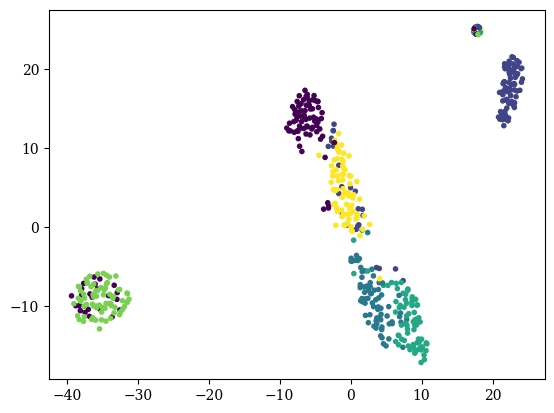

In [16]:
tsne_DN = TSNE(n_components=2, perplexity=40, learning_rate=100, random_state=42)
tsne_result_DN = tsne_DN.fit_transform(all_feature_DN)
plt.scatter(tsne_result_DN[:, 0], tsne_result_DN[:, 1], c=list(labels_DN))  # 使用'viridis'颜色地图
plt.show()

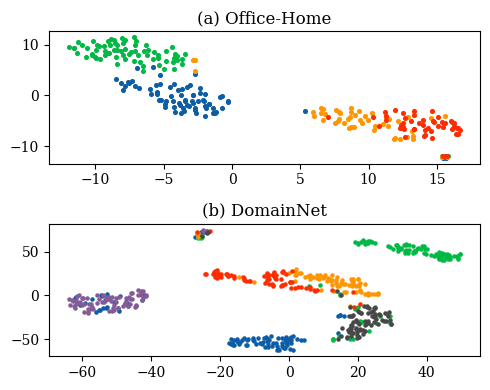

In [17]:
import matplotlib.pyplot as plt
import itertools
from sklearn.manifold import TSNE
import numpy as np

# 生成分类标签
categories = ['a', 'b', 'c', 'd']
categories_DN = ['a', 'b', 'c', 'd', 'e', 'f']
label_DN = [0,1,2,3,4,5,0,1,2,3,4,5,0,1,2,3,4,5,0,1]
label = [0,1,2,3,0,1,2,3,0,1]
labels_DN = list(itertools.chain.from_iterable([[i]*25 for i in label_DN ]))
labels = list(itertools.chain.from_iterable([[i]*25 for i in label ]))
# 运行 t-SNE
tsne_OF = TSNE(n_components=2, perplexity=40, learning_rate=100, random_state=42)
tsne_result_OF = tsne_OF.fit_transform(all_feature)

tsne_DN = TSNE(n_components=2, perplexity=10, learning_rate=400, random_state=42)
tsne_result_DN = tsne_DN.fit_transform(all_feature_DN)
plt.show()
# 创建子图
fig, axes = plt.subplots(2, 1, figsize=(5, 4)) # 调整figsize以留出空间放置图例

# 绘制散点图并为每个类别添加一个代表点以用于图例
for i, category in enumerate(categories):
    subset = tsne_result_OF[np.array(list(labels)) == i]
    axes[0].scatter(subset[:, 0], subset[:, 1], label=category, s=7)
axes[0].set_title('(a) Office-Home')
# axes[0].legend()

for i, category in enumerate(categories_DN):
    subset = tsne_result_DN[np.array(list(labels_DN)) == i]
    axes[1].scatter(subset[:, 0], subset[:, 1], label=category, s=5)
axes[1].set_title('(b) DomainNet')
# axes[1].legend()
plt.tight_layout()
# 显示图形
plt.show()

In [18]:
subset

array([[-23.43263   ,  73.09841   ],
       [ 23.783083  , -18.990778  ],
       [ 29.557026  , -32.828415  ],
       [ 18.712603  , -42.69466   ],
       [ 18.072508  , -38.465057  ],
       [ 27.929258  , -20.267372  ],
       [ 17.823086  , -36.798954  ],
       [ 20.04106   , -47.45406   ],
       [ 26.015203  , -20.831026  ],
       [ 23.94271   , -34.26705   ],
       [ 20.747086  , -38.84242   ],
       [ 20.663406  , -40.04902   ],
       [ 15.111242  ,   0.21246776],
       [ 19.597145  , -38.30407   ],
       [ 18.374493  , -23.014786  ],
       [ 18.547554  , -22.34322   ],
       [ 22.3439    , -32.157505  ],
       [ 27.639103  , -29.316381  ],
       [ 17.955652  , -34.36961   ],
       [ 18.25339   , -35.294636  ],
       [ 24.327425  , -18.189045  ],
       [ 19.552164  , -36.834118  ],
       [ 22.204218  , -33.869904  ],
       [ 24.886927  , -21.074528  ],
       [ 17.446064  , -41.52118   ],
       [-23.853636  ,  71.572205  ],
       [ 18.668226  , -29.922153  ],
 